<img src="../meta/logo.png" width=400 align="left"/>

Contributors:
- *Liubov Elkhovskaya* <span style="color:blue">lelkhovskaya@itmo.ru</span>
- *Alexander Kshenin* <span style="color:blue">Ksh_sa@mail.ru</span>
- *Marina Balakhontceva* <span style="color:blue">mbalakhontceva@itmo.ru</span>
- *Sergey Kovalchuk* <span style="color:blue">kovalchuk@itmo.ru</span>

ProFIT автоматически строит модели бизнес-процессов по данным. Входные данные — журнал событий, содержащий записи об идентификаторах случаев и выполненных действиях, упорядоченные по времени регистрации в системе. Модель процесса представлена в виде ориентированного графа, где зелёная вершина — начало процесса, а красная — конец.

<img src="../meta/pm_general.png" width=600 align="center"/>

## Import

Ссылка на проект: https://github.com/Siella/ProFIT.

In [1]:
import sys

PACKAGE_PATH = '../jupyter-workspace/ProFIT'
sys.path.append(PACKAGE_PATH)
sys.path.append(PACKAGE_PATH + '/profit')

In [2]:
from profit import ProcessMap

## How to use

Чтобы начать использовать ProFIT, достаточно объявить и присвоить пременной экземпляр класса ProcessMap, а затем передать путь к логу в формате CSV/TXT/XES (либо сами данные в виде pandas.DataFrame) через метод set_log.

In [3]:
monitoring = "../jupyter-workspace/ProFIT/demo/log_examples/remote_monitoring.csv"
declarations = "../jupyter-workspace/ProFIT/demo/log_examples/DomesticDeclarations.xes"

In [4]:
import pandas as pd

# log demo
df_monitoring = pd.read_csv(monitoring, encoding='cp1251')
df_monitoring.head()

,case_id,task,timestamp
0,4082,нов.прогр_оператор,2018-01-10 00:00:03
1,4082,КЗ_оператор,2018-01-10 22:09:21
2,4173,нов.прогр_оператор,2018-01-12 00:00:04
3,4176,нов.прогр_оператор,2018-01-12 00:00:04
4,4082,КЗ_врачФД,2018-01-12 02:44:28


In [5]:
pm = ProcessMap()

In [6]:
pm.set_log(FILE_PATH = monitoring, 
#            data = df_monitoring,
           encoding = 'cp1251')

pm.update()

После каждой настройки необходимо вызвать метод update!

Метод render возвращает модель процесса в виде ориентированного графа на DOT языке (поддерживается и визуализируется пакетом утилит Graphviz). Чтобы показать и сохранить модель в формате, поддерживаемом Graphviz, нужно вызвать данный метод и указать путь к директории, где будет сохранён результат.

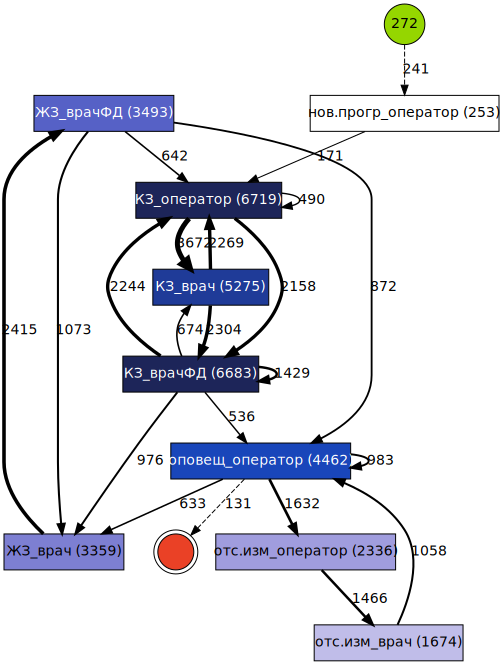

In [7]:
# without saving
pm.render()

С помощью методов set_rates и set_params пользователь может настроить несколько входных параметров: 
- уровни отображения событий и переходов, регулирующие детализацию модели процесса; 
- опцию построения оптимальной модели процесса, основанной на комбинированной оценке сложности и точности модели;
- параметр оптимизации, регулирующий простоту восприятия и полноту модели;
- опцию выделения мета-состояний путём агрегации циклов в модели; 
- способы агрегации и проч. (см. документацию)

По умолчанию (без настроек) ищется оптимальная модель процесса, поэтому при изменении уровней отображений необходимо выставить optimize=False, чтобы отключить их автонастройку. Задача оптимизации выглядит следующим образом:

$$\mathcal{Q}(p, X^l) = (1-\lambda)\cdot F + \lambda\cdot C_{\mathcal{J}} \longrightarrow \min_{\theta},$$

где $\mathcal{Q}$ — функционал качества, $p$ — алгоритм извлечения модели процесса из данных, $X^l$ — подвыборка лога, $\lambda$ — коэффициент регуляризации, $F$ — фитнес-функция, $C_\mathcal{J}$ — функция сложности, $\theta$ — уровни отображений.

In [8]:
pm2 = ProcessMap()
pm2.set_log(FILE_PATH=declarations)
pm2.update()

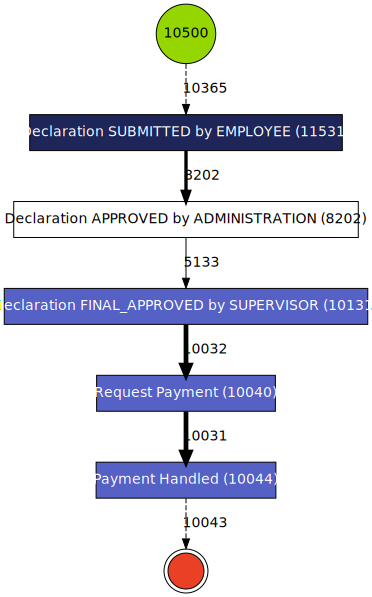

In [9]:
pm2.render()

In [10]:
pm.set_rates(activity_rate=80, path_rate=15)
pm.set_params(optimize=False, aggregate=False)

pm.update()

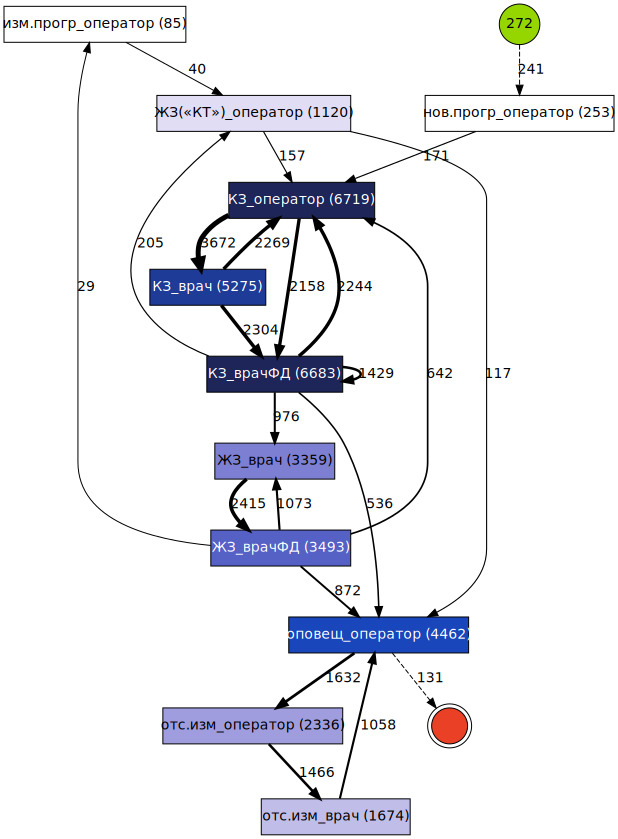

In [11]:
pm.render()

### Meta-states discovering

Под мета-состояниями понимаем значимые циклы, то есть которые часто встречаются в логе.

<img src="../meta/cycles_joining.png" width=600 align="center"/>

<center>Пример перестроения модели процесса (a) изначальная модель; (b) свёртка циклов типа outer joining; 
(c) свёртка циклов типа inner joining и эвристикой all; (d) свёртка циклов типа inner joining и эвристикой frequent</center>

In [12]:
pm.set_rates(activity_rate=80, path_rate=5)
pm.set_params(optimize=False, 
              aggregate=True,
              heuristic='all',
              agg_type='inner')

pm.update()

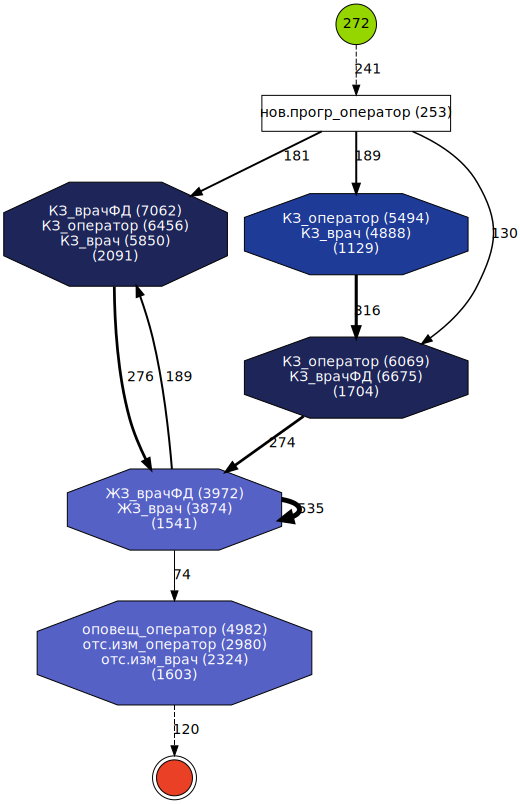

In [13]:
pm.render()